# Analyse results from Pypsa-Earth
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Import packages

In [229]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy
import glob
import logging

## Settings

### Set project root

In [230]:
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")

PARENT = os.path.realpath("pypsa-earth") + os.sep

### Load configuration

In [231]:
with open(os.path.join(PARENT, "config.yaml"), "r") as f:
    cfg = yaml.safe_load(f)

run = cfg.get("run", {}) or {}
scen = cfg.get("scenario", {}) or {}
costs = cfg.get("costs", {}) or {}
expo = cfg.get("export", {}) or {}

results_dir = (cfg.get("results_dir", "results/") or "results/").strip("/") + "/"

### Set add-on file paths

In [232]:
scenario_name = cfg["run"]["name"]
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
network_path = PARENT + f"networks/{scenario_subpath}elec.nc"
# Country shape file
regions_onshore_path = PARENT + f"resources/{scenario_subpath}shapes/country_shapes.geojson"
# Renewable profile file
solar_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_solar.nc"
onwind_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_onwind.nc"

### Directory definitions

In [233]:
RDIR = (run.get("name") or "").strip()
RDIR = (RDIR + "/") if RDIR else ""

# Scan for solved networks to analyse
result_dir = os.path.join(PARENT, results_dir, RDIR, "postnetworks")

### Wildcard helper

In [234]:
def pick(val, allow_empty=False):
    """
    Return single value if exactly one is given.
    Return '*' if multiple values or empty (unless allow_empty=True).
    """
    if val is None:
        return "*"
    if isinstance(val, (list, tuple)):
        if len(val) == 1:
            s = "" if val[0] is None else str(val[0])
            return s if (allow_empty or s != "") else "*"
        return "*"
    s = "" if val is None else str(val)
    return s if (allow_empty or s != "") else "*"

### Build wildcard segments

In [235]:
simpl = pick(scen.get("simpl", [""]), allow_empty=True)
clusters = pick(scen.get("clusters"))
ll = pick(scen.get("ll"))
opts = pick(scen.get("opts"))
sopts = pick(scen.get("sopts", [""]), allow_empty=True)
plan = pick(scen.get("planning_horizons"))
dr = pick(costs.get("discountrate"))
demand = pick(scen.get("demand"))

h2_raw = pick(expo.get("h2export"))
h2 = (h2_raw + "export") if h2_raw != "*" else "*export"

### Pattern builders

In [236]:
patterns = [
    os.path.join(result_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"),
    os.path.join(result_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}_*.nc"),
]

### Find networks

In [237]:
all_matches = []
for pat in patterns:
    all_matches.extend(glob.glob(pat))

# remove duplicates
all_matches = sorted(set(all_matches), key=os.path.getmtime)

if not all_matches:
    recent = sorted(
        glob.glob(os.path.join(PARENT, results_dir, "**", "*.nc"), recursive=True),
        key=os.path.getmtime
    )[-20:]
    recent_txt = "\n".join(os.path.relpath(p, PARENT) for p in recent) or "(none)"
    raise FileNotFoundError(
        "No network matched.\n"
        "Here are the last few .nc files under results/:\n"
        f"{recent_txt}"
    )

print("Found networks:")
for m in all_matches:
    print("-", os.path.relpath(m, PARENT))

Found networks:
- results/postnetworks/elec_s_24_ec_lcopt_Co2L-3h_144h_2030_0.071_AB_10export.nc


## Energy system analysis setup - power and energy generation

In [238]:
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pypsa.io").setLevel(logging.ERROR) # ignore warnings

chosen = all_matches[-1]  # choose newest one
n = pypsa.Network(chosen)

regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
gadm_shapes = gpd.read_file(PARENT + f"resources/shapes/gadm_shapes.geojson")
warnings.simplefilter(action='default', category=FutureWarning)

## Data import check

Plot of the region of interest

Text(0.5, 1.0, 'BJ, NG')

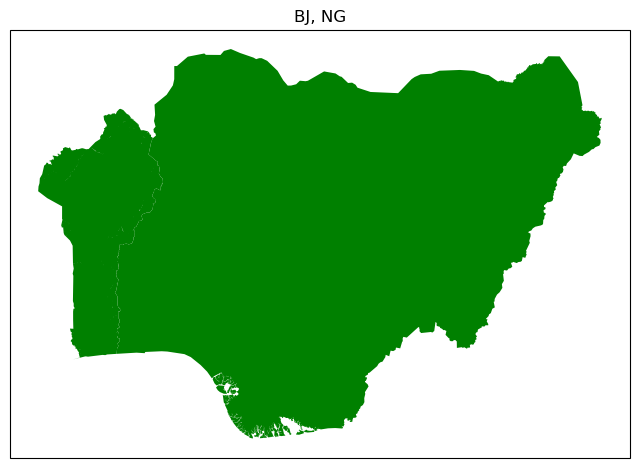

In [239]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.PlateCarree()})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

List number of components by type

In [240]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 604 entries
Component 'Carrier' has 134 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 26 entries
Component 'LineType' has 35 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 1576 entries
Component 'Load' has 731 entries
Component 'Generator' has 914 entries
Component 'StorageUnit' has 2 entries
Component 'Store' has 411 entries


List the snapshots of the PyPSA network

In [241]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01', '2013-01-07', '2013-01-13', '2013-01-19',
               '2013-01-25', '2013-01-31', '2013-02-06', '2013-02-12',
               '2013-02-18', '2013-02-24', '2013-03-02', '2013-03-08',
               '2013-03-14', '2013-03-20', '2013-03-26', '2013-04-01',
               '2013-04-07', '2013-04-13', '2013-04-19', '2013-04-25',
               '2013-05-01', '2013-05-07', '2013-05-13', '2013-05-19',
               '2013-05-25', '2013-05-31', '2013-06-06', '2013-06-12',
               '2013-06-18', '2013-06-24', '2013-06-30', '2013-07-06',
               '2013-07-12', '2013-07-18', '2013-07-24', '2013-07-30',
               '2013-08-05', '2013-08-11', '2013-08-17', '2013-08-23',
               '2013-08-29', '2013-09-04', '2013-09-10', '2013-09-16',
               '2013-09-22', '2013-09-28', '2013-10-04', '2013-10-10',
               '2013-10-16', '2013-10-22', '2013-10-28', '2013-11-03',
               '2013-11-09', '2013-11-15', '2013-11-21', '2013-11-27',
      

## Analyse energy system

Analyse the current capacity of the energy system - map view

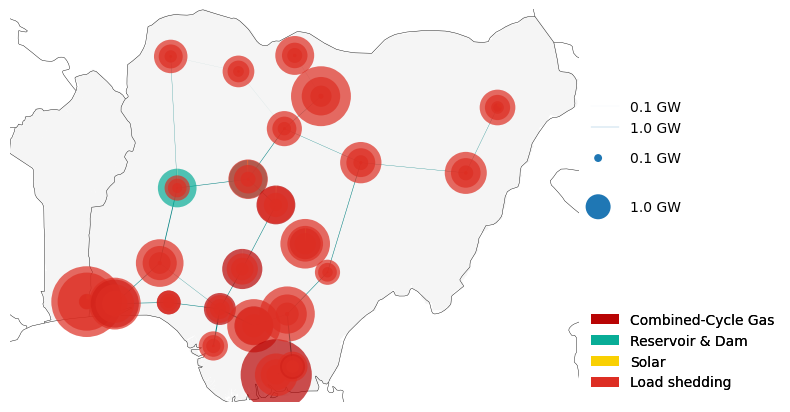

In [242]:
warnings.simplefilter(action='ignore', category=UserWarning)
# --- Scale settings ---
bus_scale = 6e3 
line_scale = 6e3

# --- Legend settings ---
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

# --- Remove "Load" carrier for plotting ---
if "Load" in n.carriers.index:
    n.carriers.drop("Load", inplace=True)

# --- Aggregate generator and storage capacities by bus and carrier ---
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# --- Filter Links: only those that lie within GADM regions ---
# Extract the base part of the bus names
link_bus0_base = n.links.bus0.str.split("_AC").str[0]
link_bus1_base = n.links.bus1.str.split("_AC").str[0]

# Keep only links whose both ends are present in the GADM shapes
valid_links = n.links[
    link_bus0_base.isin(gadm_shapes.index) &
    link_bus1_base.isin(gadm_shapes.index) &
    (n.links.p_nom > 0)  # optional: only positive capacity
]

# overwrite temporarily for the plot
links_backup = n.links
n.links = valid_links

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )

regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

# Set map extent
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])

# --- Add legends ---
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)

# --- Create patch legend for carriers (unique nice_name, non-zero capacity) ---
colors_legend = []
labels_legend = []
seen = set()
for c in n.carriers.index:
    name = n.carriers.loc[c, 'nice_name']
    color = n.carriers.loc[c, 'color']

    # Sum capacity over all buses for this carrier
    if c in buses.index.get_level_values('carrier'):
        val_total = buses.xs(c, level='carrier').sum()
    else:
        val_total = 0

    if name not in seen and val_total > 0:
        seen.add(name)
        colors_legend.append(color)
        labels_legend.append(name)

add_legend_patches(
    ax,
    colors_legend,
    labels_legend,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc": "lower left"},
)

fig.tight_layout()
plt.show()

# Restore original links
n.links = links_backup
warnings.simplefilter(action='default', category=UserWarning)

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier (GW)')

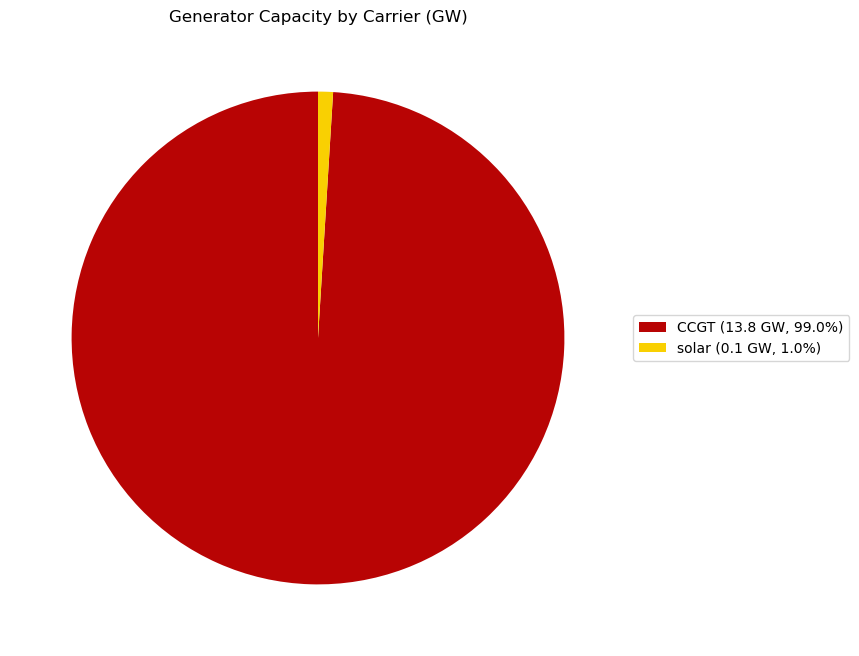

In [243]:
# --- Extract data for current energy carriers ---
generator_capacity_by_carrier = (
    n.generators[~n.generators.carrier.str.contains("load", case=False)]
    .groupby("carrier")
    .p_nom.sum()
    .div(1e3)  # Convert to GW
    .sort_values(ascending=False)
)
# --- Filter: keep only entries > 0 ---
generator_capacity_by_carrier = generator_capacity_by_carrier[generator_capacity_by_carrier > 0]

plt.figure(figsize=(8, 8))
wedges, _ = plt.pie(
    generator_capacity_by_carrier,
    labels=None,   # no labels directly in the chart
    startangle=90,
    colors=n.carriers[
            n.carriers.index.isin(generator_capacity_by_carrier.index)
        ].color.reindex(generator_capacity_by_carrier.index)
)
# Legend with capacity + share
labels = [
    f"{c} ({v:.1f} GW, {100*v/generator_capacity_by_carrier.sum():.1f}%)"
    for c, v in zip(generator_capacity_by_carrier.index, generator_capacity_by_carrier.values)
]
plt.legend(
    wedges,
    labels,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title("Generator Capacity by Carrier (GW)")

Analyse the current gernation capacity of the energy system - tabular view

In [244]:
generator_capacity_by_carrier

carrier
CCGT     13.826948
solar     0.136622
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

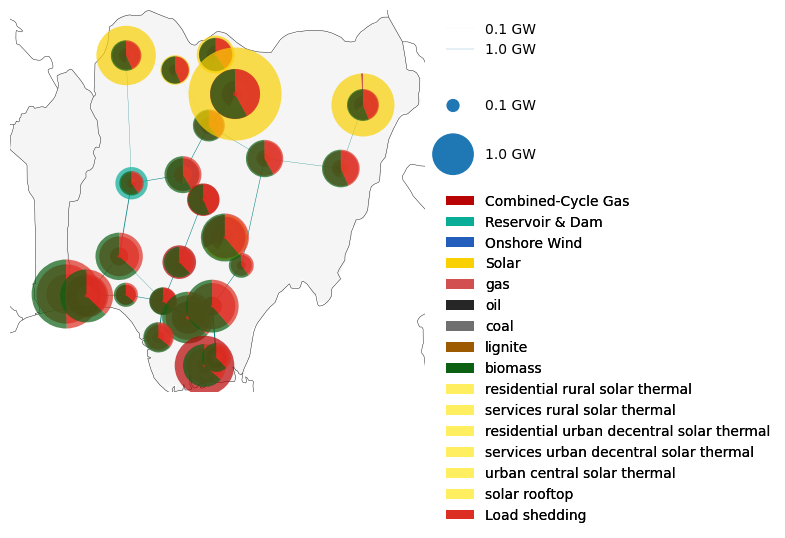

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth()})

# --- Aggregate capacities ---
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

# --- Filter links ---
link_bus0_base = n.links.bus0.str.split("_AC").str[0]
link_bus1_base = n.links.bus1.str.split("_AC").str[0]
valid_links = n.links[
    link_bus0_base.isin(gadm_shapes.index) &
    link_bus1_base.isin(gadm_shapes.index) &
    (n.links.p_nom_opt > 0)
]
links_backup = n.links
n.links = valid_links

plot_boundaries = regions_onshore.total_bounds[[0, 2, 1, 3]]

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        color_geomap=None,
        boundaries=plot_boundaries
    )

regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

# Restore original links
n.links = links_backup

# --- Add legends ---
legend_kwargs = {"loc": "upper left", "frameon": False}

# Line legend (Top)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1.02, 1.0), **legend_kwargs},
)

# Circle legend (Middle)
legend_circles_dict = {"bbox_to_anchor": (1.02, 0.8), "labelspacing": 2.5, **legend_kwargs} # Changed 0.85 to 0.8
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)

# --- Create patch legend for carriers (unique nice_name, non-zero capacity) ---
colors_legend = []
labels_legend = []
seen = set()
for c in n.carriers.index:
    name = n.carriers.loc[c, 'nice_name']
    color = n.carriers.loc[c, 'color']

    # Sum capacity over all buses for this carrier
    if c in buses.index.get_level_values('carrier'):
        val_total = buses.xs(c, level='carrier').sum()
    else:
        val_total = 0

    if name not in seen and val_total > 0:
        seen.add(name)
        colors_legend.append(color)
        labels_legend.append(name)

# Patch legend (Bottom)
add_legend_patches(
    ax,
    colors_legend,
    labels_legend,
    legend_kw={"bbox_to_anchor": (1.02, 0.55), **legend_kwargs}, # Changed 0.65 to 0.55
)

fig.tight_layout()
warnings.simplefilter(action="default", category=UserWarning)

Analys the future generation capacity expansion of the energy system - bar chart

<Axes: title={'center': 'Generator capacity expansion in GW'}, xlabel='carrier'>

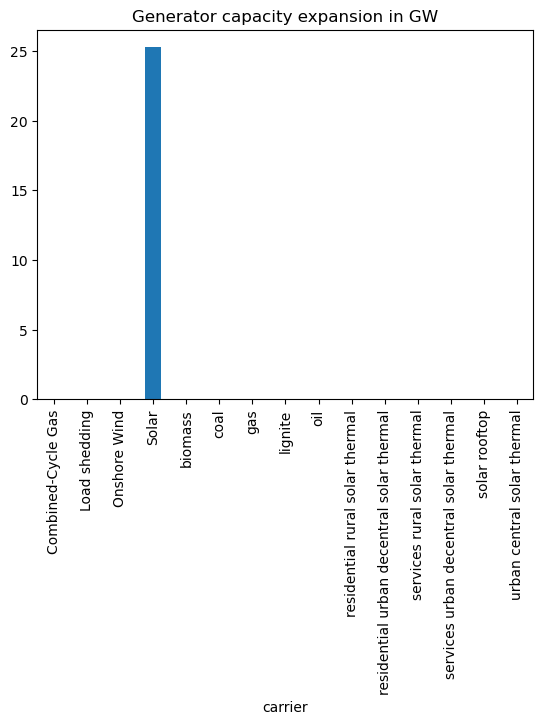

In [246]:
optimal_capacity = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True, errors='ignore')
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [247]:
generation_capacity_expansion # In GW

carrier
Combined-Cycle Gas                            0.000000
Load shedding                                 0.000000
Onshore Wind                                       NaN
Solar                                        25.260129
biomass                                            NaN
coal                                               NaN
gas                                                NaN
lignite                                            NaN
oil                                                NaN
residential rural solar thermal                    NaN
residential urban decentral solar thermal          NaN
services rural solar thermal                       NaN
services urban decentral solar thermal             NaN
solar rooftop                                      NaN
urban central solar thermal                        NaN
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

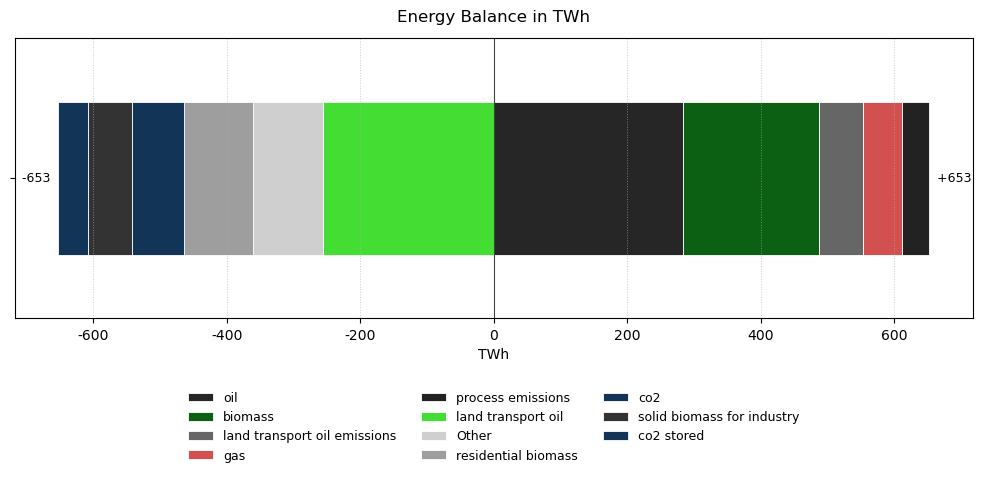

In [248]:
# Rename columns for better readability
rename_cols = {
    "-": "Load",
    "load": "load shedding",
}

# Calculate the energy balance, aggregate by carrier, and convert MWh to TWh
energy_balance = (
    n.statistics.energy_balance()
    .loc[:, :, :]
    # .loc[:, :, "AC"] nur Stromsystem
    .groupby("carrier")
    .sum()
    .div(1e6)  # Convert MWh to TWh
    .to_frame()
    .T
    .rename(columns=rename_cols)
)

# Remove carriers with no energy flow
energy_balance = energy_balance.loc[:, (energy_balance != 0).any(axis=0)]

# Build color lookup from cfg
colors = {k.lower(): v for k, v in cfg["plotting"]["tech_colors"].items()}
nice_names = {v.lower(): k for k, v in cfg["plotting"]["nice_names"].items()}

def color_for(col):
    original = col.lower()
    key = nice_names.get(original, original).lower()
    return colors.get(key, "#9e9e9e")  # fallback gray

# --- Order by absolute contribution, keep top 10, roll rest into "Other" ---
top_n = 10
s = energy_balance.iloc[0]
ordered = s.reindex(s.abs().sort_values(ascending=False).index)

top_cols = ordered.index[:top_n].tolist()
other_cols = ordered.index[top_n:].tolist()

df_plot = energy_balance[top_cols].copy()
if other_cols:
    df_plot["Other"] = energy_balance[other_cols].sum(axis=1)

# Order within the stack: positives (largest→smallest), then negatives (smallest→largest)
pos = df_plot.iloc[0][df_plot.iloc[0] > 0].sort_values(ascending=False)
neg = df_plot.iloc[0][df_plot.iloc[0] < 0].sort_values(ascending=True)
stack_order = list(pos.index) + list(neg.index)
df_plot = df_plot[stack_order]

# --- Build color list ---
color_list = [color_for(c) if c != "Other" else "#cfcfcf" for c in df_plot.columns]

# --- Plot horizontal stacked bar ---
fig, ax = plt.subplots(figsize=(10, 4.5))
df_plot.plot.barh(
    stacked=True, ax=ax, color=color_list, edgecolor="white", linewidth=0.6, width=0.6
)
ax.set_title("Energy Balance in TWh", pad=12)
ax.set_xlabel("TWh")
ax.set_ylabel("")
ax.set_yticklabels([""])  # hide category label
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))
ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.6)
ax.axvline(0, color="#444", linewidth=0.8)

# --- Build legend ---
nice_labels = [cfg["plotting"]["nice_names"].get(c, c) for c in df_plot.columns]
handles = [
    Patch(facecolor=color_list[i], edgecolor="white", linewidth=0.6, label=nice_labels[i])
    for i in range(len(df_plot.columns))
]
cols_in_legend = 3 if len(nice_labels) <= 18 else 4
ax.legend(
    handles=handles,
    labels=nice_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=cols_in_legend,
    frameon=False,
    fontsize=9,
    title=None,
)

# --- Annotate totals ---
vals = df_plot.iloc[0]
cum_pos = vals[vals > 0].sum()
cum_neg = vals[vals < 0].sum()
ax.text(cum_pos, 0, f"  +{int(round(cum_pos)):,}", va="center", ha="left", fontsize=9)
ax.text(cum_neg, 0, f"{int(round(cum_neg)):,}  ", va="center", ha="right", fontsize=9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.28)
plt.show()


Analyse the future energy generation of the energy system - tabular view

In [249]:
n.statistics.energy_balance()/1e6 # In TWh

component  carrier                     bus_carrier               
Store      biogas                      biogas                        9.442800e-07
           co2                         co2                          -7.745689e+01
           co2 stored                  co2 stored                   -4.499702e+01
           coal                        coal                          8.340000e-09
           lignite                     lignite                      -3.373000e-08
                                                                         ...     
Load       services electricity        low voltage                  -1.138694e+01
           services oil                oil                          -3.628596e-02
           shipping oil                oil                          -4.824797e+00
           solid biomass for industry  solid biomass for industry   -6.530243e+01
           urban central heat          urban central heat           -1.210003e+00
Length: 204, dtype: float64

## Analyse pv and wind potential - map view

In [250]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"{PARENT}resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot wind energy potential

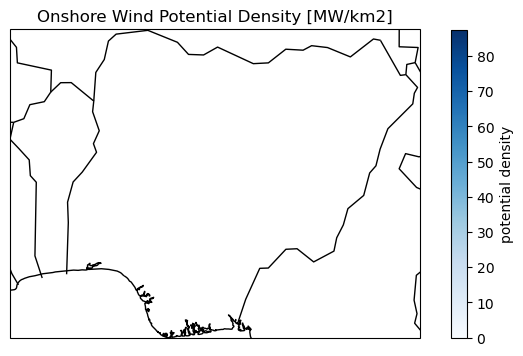

In [251]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot pv energy potential

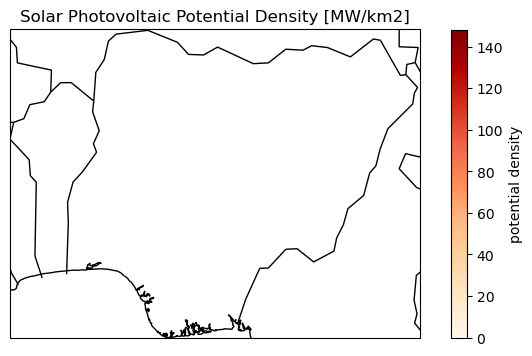

In [252]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)